<a href="https://colab.research.google.com/github/spacemaninSeoul/fast_campus_ML300/blob/main/ML300P3%ED%8C%A8%ED%84%B4%EC%9D%B8%EC%8B%9DC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 1. 철판 제조 공정 데이터를 활용한 분류모형 생성 및 성능 비교

## Step 0. 철판 제조 공정 데이터 소개 및 데이터 준비, 학습목표

**Steel Plates Faults 데이터는 1941개의 샘플을 가지며 아래의 종속변수들과 나머지 설명변수들로 구성됩니다.**

- 종속변수 (7개) - 어떠한 불량이 나타났는지를 나타내고, 다음과 같습니다.
 - Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults

- 설명변수 (27개) - 철판의 길이, 반짝이는 정도, 두께, 타입 등 등 다양한 변수들을 가집니다.
 - 첫번째 칼럼 X_Minimum ~ 27번째 칼럼 SigmoidOfAreas

- 데이터출처: https://www.kaggle.com/mahsateimourikia/faults-nna/notebooks



**제조 공정 데이터의 전반적 특성**

- 제조 공정 데이터는 주로 불량률을 예측하여 불량을 일으키는 원인을 제거하거나 재고를 예측하여 수요에 맞는 생산을 진행하는 등의 목적성을 가집니다.
- 다른 데이터에 비하여 데이터를 얻는 과정이 자동화되어 있는 경우가 많아 데이터 퀄리티가 높은 편이며 결측치가 적은 경향성을 가집니다.


### **학습목표**
```
- 각 모델들의 개괄적 이해 및 구축과정 학습.
- 파라미터를 최적화 시키는 GridSearch에 대한 이해 및 코딩작업 체화.
- 각 모델의 중요 파라미터에 대한 개괄적 이해.
- 파라미터의 변화에 따른 예측력 변화 경향성 파악.
- 최적의 모형 및 파라미터를 찾는 과정에 대한 계획 수립 및 수행.
``` 

In [ ]:
# 구글 드라이브에 내드라이브에서 P3C1폴더를 생성하여 데이터를 준비하고 이를 마운트합니다.
# 계정 인증을 한 후 코드를 복사하여 붙여넣습니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 마운트가 제대로 진행되었는지 확인합니다. 아래와 같이 폴더 안에 두 데이터 파일이 포함되어 있는 것으로 출력되어야 합니다.
# file_list: ['Faults27x7_var', 'Faults.NNA']
import os
os.chdir('/content/')
path = './drive/MyDrive/P3C1'
file_list = os.listdir(path)

print('file_list: {}'.format(file_list))

file_list: ['Faults27x7_var', 'Faults.NNA']


In [ ]:
# Working directory를 설정합니다
os.chdir('/content/drive/MyDrive/P3C1/')

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('Faults.NNA', delimiter='\t', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [ ]:
attributes_name = pd.read_csv('Faults27x7_var', header=None)

In [ ]:
attributes_name

,0
0,X_Minimum
1,X_Maximum
2,Y_Minimum
3,Y_Maximum
4,Pixels_Areas
5,X_Perimeter
6,Y_Perimeter
7,Sum_of_Luminosity
8,Minimum_of_Luminosity
9,Maximum_of_Luminosity


In [ ]:
df.columns = attributes_name[0]

In [ ]:
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [ ]:
print(df.shape)

(1941, 34)


In [ ]:
#Cpu의 개수를 확인합니다. 
n_cpu = os.cpu_count()
print('The number of cpus: ', n_cpu)
n_thread = n_cpu * 2
print('Expected number of threads', n_thread)

The number of cpus:  2
Expected number of threads 4


## Step 1. 데이터 전처리 및 탐색적 데이터 분석

### 문제 1. 종속변수 범주화 (1) - boolean Seris로 이루어진 list 구성

- 7개의 종속변수들을 각 종속변수가 1인지 아닌지 여부를 알리는 boolean 논리 연산자로 이루어진 seris 형태로 변경합니다. 각 Seris의 길이는 1941입니다.
- 이 7개의 Seris를 list로 이어 붙여 길이 7짜리 list를 만들어 conditions라는 이름으로 저장합니다. 
- 여러 방법이 존재합니다. 방법 1,2는 코드를 제공드리며 풀어주실 문제는 방법3입니다.

In [ ]:
## 방법 1. 논리적 연산자 &를 활용하여 생성합니다.
conditions=[(df['Pastry'] == 1) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0), 
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 1)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 1)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 1)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 1)& (df['Bumps'] == 0)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 1)& (df['Other_Faults'] == 0),
            (df['Pastry'] == 0) & (df['Z_Scratch'] == 0)& (df['K_Scatch'] == 0)& (df['Stains'] == 0)& (df['Dirtiness'] == 0)& (df['Bumps'] == 0)& (df['Other_Faults'] == 1)]



In [ ]:
## 방법 2. pandas.Series.astype을 활용합니다.
conditions = [df['Pastry'].astype(bool),
              df['Z_Scratch'].astype(bool),
              df['K_Scatch'].astype(bool),
              df['Stains'].astype(bool),
              df['Dirtiness'].astype(bool),
              df['Bumps'].astype(bool),
              df['Other_Faults'].astype(bool)
              ]

In [21]:
## (문제) 방법 3. pandas.Series.astype과 map, lambda를 활용합니다
# conditions_bf에 각 변수들의 Seris로 list를 구성합니다.
# conditions_bf을 사용하고 map, lambda를 활용하여 conditions_bf의 각 원소에 astype 함수를 적용합니다.

conditions_bf = [
                 df['Pastry'],
                 df['Z_Scratch'],
                 df['K_Scatch'],
                 df['Stains'],
                 df['Dirtiness'],
                 df['Bumps'],
                 df['Other_Faults']
]

conditions = list(map(lambda i: i.astype(bool), conditions_bf))

In [22]:
print(conditions)

[0        True
1        True
2        True
3        True
4        True
        ...  
1936    False
1937    False
1938    False
1939    False
1940    False
Name: Pastry, Length: 1941, dtype: bool, 0       False
1       False
2       False
3       False
4       False
        ...  
1936    False
1937    False
1938    False
1939    False
1940    False
Name: Z_Scratch, Length: 1941, dtype: bool, 0       False
1       False
2       False
3       False
4       False
        ...  
1936    False
1937    False
1938    False
1939    False
1940    False
Name: K_Scatch, Length: 1941, dtype: bool, 0       False
1       False
2       False
3       False
4       False
        ...  
1936    False
1937    False
1938    False
1939    False
1940    False
Name: Stains, Length: 1941, dtype: bool, 0       False
1       False
2       False
3       False
4       False
        ...  
1936    False
1937    False
1938    False
1939    False
1940    False
Name: Dirtiness, Length: 1941, dtype: bool, 0       False
1 

### 문제 2. 종속변수 범주화 (2) - numpy.select를 활용한 범주화
- 범주화 시 범주명은 각 종속변수의 칼럼명을 그대로 활용합니다.
- (핵심) select 함수는 list 각 원소별로 TRUE인 것들의 값을 지정해줍니다.
- 범주화하여 기존 데이터프레임에 새로운 칼럼 'class'로 저장합니다.

In [23]:
choices = ['Pastry', 'z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

In [24]:
# (문제) numpy.select를 사용하고 위에 정의해드린 choices를 인수로 활용하여 범주화를 진행합니다.
df['class'] = np.select(conditions, choices)

In [26]:
np.select(conditions,choices)

array(['Pastry', 'Pastry', 'Pastry', ..., 'Other_Faults', 'Other_Faults',
       'Other_Faults'], dtype='<U21')

In [25]:
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,class
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0,Pastry
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0,Pastry
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0,Pastry
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0,Pastry
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0,Pastry


### 문제 3. EDA - 결측치 확인하기

In [27]:
# (문제) pandas.isnull를 활용해 모든 변수에 대하여 결측치가 얼마나 존재하는지를 파악합니다.
df.isnull().sum()

0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
class                    0
dtype: int64

### 문제 4. EDA - 기술통계량 파악하기
- pandas.DataFrame.describe를 활용해 기술통계량을 파악합니다.
 - min과 25% Quantile, max와 75% Quantile을 비교해 이상치 존재가능성에 대해서 파악할 수 있습니다.
 - mean과 50% Quantile을 비교하여 분포의 치우침 정도를 파악할 수 있습니다.
 - 범주형 변수에 대해서는 정보가 제한적입니다
- pandas.Series.value_counts를 활용해 범주화한 종속변수의 기술통계량을 파악합니다.
 - 어떠한 불량타입이 많이 분포하고 적게 분포하는지 파악할 수 있습니다.
 - 적게 분포하는 불량타입의 경우는 예측모형을 구축하는 것이 상대적으로 더 어려울 것입니다.

In [28]:
# (문제) pandas.DataFrame.describe를 활용해 기술통계량을 파악합니다.
df.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,1459.160227,0.400309,0.599691,78.737764,0.331715,0.414203,0.570767,0.033361,0.610529,0.813472,0.575734,2.492388,1.335686,1.403271,0.083288,-0.131305,0.585420,0.081401,0.097888,0.201443,0.037094,0.028336,0.207110,0.346728
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,144.577823,0.490087,0.490087,55.086032,0.299712,0.137261,0.271058,0.058961,0.243277,0.234274,0.482352,0.788930,0.481612,0.454345,0.500868,0.148767,0.339452,0.273521,0.297239,0.401181,0.189042,0.165973,0.405339,0.476051
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,1227.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.048400,0.000000,0.301000,0.301000,0.000000,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,1358.000000,0.000000,0.000000,40.000000,0.060400,0.315800,0.361300,0.006600,0.411800,0.596800,0.000000,1.924300,1.000000,1.079200,-0.333300,-0.195000,0.248200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,1364.000000,0.000000,1.000000,70.000000,0.227300,0.412100,0.555600,0.010100,0.636400,0.947400,1.000000,2.240600,1.176100,1.322200,0.095200,-0.133000,0.506300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,1650.000000,1.000000,1.000000,80.000000,0.573800,0.501600,0.818200,0.023500,0.800000,1.000000,1.000000,2.914900,1.518500,1.732400,0.511600,-0.066600,0.999800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,1794.000000,1.000000,1.000000,300.000000,0.995200,0.943900,1.000000,0.875900,1.000000,1.000000,1.000000,5.183700,3.074100,4.258700,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
df['class'].value_counts()

Other_Faults    673
Bumps           402
K_Scatch        391
z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: class, dtype: int64

### 문제 5. 산점도를 통한 변수간의 상관관계 파악

In [30]:
import matplotlib.pyplot as plt

In [31]:
color_code = {'Pastry':'Red', 'Z_Scratch':'Blue', 'K_Scatch':'Green', 'Stains':'Black', 'Dirtiness':'Pink', 'Bumps':'Brown', 'Other_Faults':'Gold'}

In [32]:
# (문제) for문과 위에 정의해드린 dictionary를 활용하여 데이터의 각 행에 해당하는 color값을 지정하는 list를 생성하여 color_list에 저장합니다.
color_list = [color_code.get(i) for i in df.loc[:, 'class']]

### 문제 6. 범주형 변수의 분포 시각화

In [35]:
import seaborn as sns
sns.set_style('white')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


158
-0.2
190
0.8
391
1.8
72
2.8000000000000003
55
3.8000000000000003
402
4.8
673
5.8


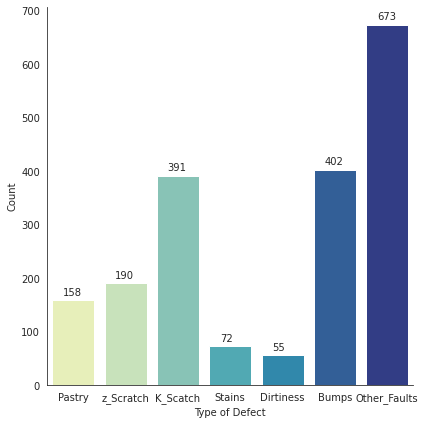

In [39]:
# (문제) seaborn.factorplot을 활용하여 Barplot으로 "class" 변수의 카운트를 표현합니다. 적절한 x축, y축, plot의 title까지 지정해줍니다.
g = sns.factorplot(x='class', data=df, kind='count', palette = 'YlGnBu',size=6)
g.ax.xaxis.set_label_text('Type of Defect')
g.ax.yaxis.set_label_text('Count')

# (문제) Barplot의 bar 상단에 값을 text로 달아줍니다.

for p in g.ax.patches:
  g.ax.annotate((p.get_height()), (p.get_x()+0.2, p.get_height()+10))
  print(p.get_height())
  print(p.get_x()+0.2)

### 문제 7. 상관계수를 활용한 변수간의 상관관계 파악

In [42]:
df.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults', 'class'],
      dtype='object', name=0)

In [41]:
df_corTarget = df[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']]


In [43]:
# (문제) df_corTarget에 대하여, pandas.DataFrame.corr 을 활용해 correlation을 구한 뒤 corr에 저장.
corr = df_corTarget.corr()
corr

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,,,,,,,,,,,,,,,,,,,,,,,,,,,
X_Minimum,1.000000,0.988314,0.041821,0.041807,-0.307322,-0.258937,-0.118757,-0.339045,0.237637,-0.075554,0.316662,0.144319,-0.144319,0.136625,0.278075,-0.198461,0.063658,-0.361160,0.154778,0.367907,0.147282,-0.428553,-0.437944,-0.326851,0.178585,-0.031578,-0.355251
X_Maximum,0.988314,1.000000,0.052147,0.052135,-0.225399,-0.186326,-0.090138,-0.247052,0.168649,-0.062392,0.299390,0.112009,-0.112009,0.106119,0.242846,-0.152680,0.048575,-0.214930,0.149259,0.271915,0.099253,-0.332169,-0.324012,-0.265990,0.115019,-0.038996,-0.286736
Y_Minimum,0.041821,0.052147,1.000000,1.000000,0.017670,0.023843,0.024150,0.007362,-0.065703,-0.067785,-0.049211,0.075164,-0.075164,-0.207640,0.021314,-0.043117,-0.006135,0.054165,0.066085,-0.036543,-0.062911,0.044952,0.070406,-0.008442,-0.086497,-0.090654,0.025257
Y_Maximum,0.041807,0.052135,1.000000,1.000000,0.017840,0.024038,0.024380,0.007499,-0.065733,-0.067776,-0.049219,0.075151,-0.075151,-0.207644,0.021300,-0.043085,-0.006152,0.054185,0.066051,-0.036549,-0.062901,0.044994,0.070432,-0.008382,-0.086480,-0.090666,0.025284
Pixels_Areas,-0.307322,-0.225399,0.017670,0.017840,1.000000,0.966644,0.827199,0.978952,-0.497204,0.110063,-0.155853,-0.235591,0.235591,-0.183735,-0.275289,0.272808,0.017865,0.588606,-0.294673,-0.463571,-0.109655,0.650234,0.603072,0.578342,-0.137604,-0.043449,0.422947
X_Perimeter,-0.258937,-0.186326,0.023843,0.024038,0.966644,1.000000,0.912436,0.912956,-0.400427,0.111363,-0.134240,-0.189250,0.189250,-0.147712,-0.227590,0.306348,0.004507,0.517098,-0.293039,-0.412100,-0.079106,0.563036,0.524716,0.523472,-0.101731,-0.032617,0.380605
Y_Perimeter,-0.118757,-0.090138,0.024150,0.024380,0.827199,0.912436,1.000000,0.704876,-0.213758,0.061809,-0.063825,-0.095154,0.095154,-0.058889,-0.111240,0.188825,-0.047511,0.209160,-0.195162,-0.136723,0.013438,0.294040,0.228485,0.344378,0.031381,-0.047778,0.191772
Sum_of_Luminosity,-0.339045,-0.247052,0.007362,0.007499,0.978952,0.912956,0.704876,1.000000,-0.540566,0.136515,-0.169331,-0.263632,0.263632,-0.204812,-0.301452,0.293691,0.049607,0.658339,-0.327728,-0.529745,-0.121090,0.712128,0.667736,0.618795,-0.158483,-0.014067,0.464248
Minimum_of_Luminosity,0.237637,0.168649,-0.065703,-0.065733,-0.497204,-0.400427,-0.213758,-0.540566,1.000000,0.429605,-0.023579,0.042048,-0.042048,0.103393,0.358915,-0.044111,0.066748,-0.487574,0.252256,0.316610,0.035462,-0.678762,-0.567655,-0.588208,0.057123,0.669534,-0.514797


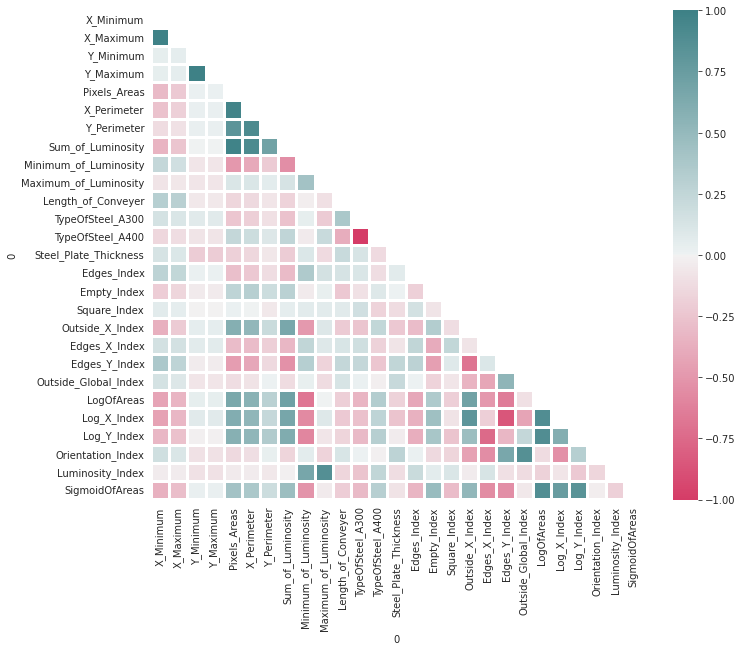

In [47]:
# heatmap을 그리기 위한 파라미터들 설정
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(1, 200, as_cmap = True)

# (문제) 저장해둔 corr과 mask, cmap을 활용하여 correlation을 표현하는 heatmap을 그립니다. correlation에 맞게 최대, 최소, 중간값을 지정해줍니다.
# linewidths=2로 설정합니다. 그림 크기는 figsize=(11,9)로 설정합니다.
sns.heatmap(corr, mask = mask, cmap = cmap, vmax=1, vmin=-1, center=0, linewidths=2, annot=False)

### 문제 8. Training, Test set 분리하기

In [48]:
x = df[['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300',  'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']]
y = df['K_Scatch']

In [49]:
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

In [50]:
# (문제) sklearn.model_selection.train_test_split을 활용하여, x_train, x_test, y_train, y_test로 데이터를 나눕니다
# 그 비율은 8:2로 합니다. y값에 따라 stratify하여 나눕니다.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

In [51]:
# (문제) pandas.DataFrame.apply를 활용하여  x_train과 x_test를 표준화합니다.
x_train = x_train.apply(zscore)
x_test = x_test.apply(zscore)

In [52]:
x_train.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03
mean,-1.213233e-16,-2.146050e-19,-1.881370e-17,-2.560953e-17,-1.001490e-17,-4.138299e-17,1.087667e-17,-2.353501e-17,2.148911e-16,-6.466584e-16,4.962382e-16,3.161847e-17,4.141876e-17,7.825928e-17,-1.226467e-16,6.717135e-17,-3.912964e-17,1.362384e-16,-2.306288e-16,-2.947242e-17,2.742651e-16,1.005782e-16,-1.280476e-17,1.645305e-17,4.921607e-17,1.347719e-16
std,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00
min,-1.103367e+00,-1.241076e+00,-9.104613e-01,-9.104788e-01,-3.483794e-01,-3.406371e-01,-1.767603e-01,-3.893515e-01,-2.643140e+00,-5.071400e+00,-1.605681e+00,-8.211077e-01,-6.967596e-01,-1.123421e+00,-3.018160e+00,-2.080335e+00,-5.289097e-01,-2.468152e+00,-3.280170e+00,-1.185811e+00,-2.774003e+00,-2.156377e+00,-3.067242e+00,-2.143465e+00,-5.839974e+00,-1.367353e+00
25%,-9.883000e-01,-8.621817e-01,-6.562362e-01,-6.562372e-01,-3.333730e-01,-3.004833e-01,-1.514077e-01,-3.719521e-01,-6.554519e-01,-3.480654e-01,-7.021989e-01,-8.211077e-01,-6.967596e-01,-9.210483e-01,-7.168723e-01,-7.749740e-01,-4.443167e-01,-7.982123e-01,-9.250766e-01,-1.185811e+00,-7.146692e-01,-6.985005e-01,-6.999318e-01,-8.252854e-01,-4.361607e-01,-9.978418e-01
50%,-2.637179e-01,-2.988794e-01,-2.545875e-01,-2.546108e-01,-3.171771e-01,-2.665069e-01,-1.260551e-01,-3.538504e-01,1.675751e-01,-1.851918e-01,-6.608181e-01,-8.211077e-01,-1.413845e-01,-3.492791e-01,-1.981697e-02,-2.493327e-02,-3.870920e-01,1.006070e-01,5.824951e-01,8.913658e-01,-3.182921e-01,-3.312158e-01,-1.668921e-01,2.490715e-02,-1.325061e-02,-2.443915e-01
75%,9.307593e-01,9.199295e-01,2.919470e-01,2.919292e-01,-2.027537e-01,-8.967550e-02,-1.144025e-02,-2.343737e-01,6.567327e-01,5.205939e-01,1.311669e+00,1.217867e+00,4.374056e-02,8.284349e-01,6.595150e-01,9.383813e-01,-1.623398e-01,7.575785e-01,7.858832e-01,8.913658e-01,5.254920e-01,3.829141e-01,7.329140e-01,8.448359e-01,4.324923e-01,1.226000e+00
max,2.180122e+00,2.203231e+00,6.155444e+00,6.155404e+00,2.758779e+01,3.192762e+01,3.817116e+01,2.140560e+01,3.661558e+00,6.601209e+00,2.304809e+00,1.217867e+00,4.116492e+00,2.211034e+00,3.880404e+00,1.563140e+00,1.397465e+01,1.578793e+00,7.858832e-01,8.913658e-01,3.420237e+00,3.627366e+00,6.274553e+00,1.830314e+00,5.180199e+00,1.226589e+00


## Step 2. 로지스틱 분류 모형


### 문제 9. [로지스틱 회귀분석] 로지스틱 기본 모형 만들기

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [54]:
# (문제) 로지스틱 회귀분석 모형을 만들어 lm에 저장합니다. solver는 'liblinear'로 설정합니다.
lm = LogisticRegression(solver='liblinear')

### 문제 10. [로지스틱 회귀분석] Grid Search 구축 (Lidge, Lasso Penalty / Threshold)

In [55]:
# (문제) 로지스틱에서 고려해야할 Penalty의 형태 (Ridge, Lasso), regularization parameter range를 설정하여 이를 parameters에 dictionary 형태로 저장합니다.
parameters = {'penalty':['l1','l2'], 'C':[0.01, 0.1, 0.5, 0.9, 1, 5, 10], 'tol':[1e-4, 1e-2, 1, 1e2]}

In [58]:
# (문제) sklearn.model_selection.GridSearchCV를 활용해 cv값 10, n_jobs값은 n_thread로, scoreing은 "accuracy"로 Grid Search를 세팅하고 이를 GSLR에 저장합니다.
GSLR = GridSearchCV(lm, parameters, cv=10, n_jobs=n_thread, scoring ='accuracy')

In [59]:
# (문제) Grid Search를 fit함수를 활용하여 수행합니다.
GSLR.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(solver='liblinear'), n_jobs=4,
             param_grid={'C': [0.01, 0.1, 0.5, 0.9, 1, 5, 10],
                         'penalty': ['l1', 'l2'],
                         'tol': [0.0001, 0.01, 1, 100.0]},
             scoring='accuracy')

In [60]:
# 최적의 파라미터 값 및 정확도 (Accuracy) 출력
print('final params', GSLR.best_params_)
print('best score', GSLR.best_score_)

final params {'C': 1, 'penalty': 'l2', 'tol': 0.0001}
best score 0.9722911497105045


### 문제 11. [로지스틱 회귀분석] 모형 평가 및 최적 로지스틱 모형 구축

In [61]:
# (문제) predict 함수를 활용하여 예측 값을 구해 이를 predicted 에 저장합니다.
predicted = GSLR.predict(x_test)

In [63]:
x_test.shape

(389, 26)

In [64]:
len(predicted)

389

In [74]:
x_t

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
1113,-0.918808,-0.997993,-0.777290,-0.777307,-0.451262,-0.281683,-0.410668,-0.430093,1.123783,0.694385,-0.662633,-0.800843,0.286506,-0.653366,1.561202,-0.075400,-0.237672,-0.447941,-1.218429,-1.227189,-0.413268,0.221472,-0.552696,-1.117116,0.954420,0.276019
1440,-0.119747,-0.168401,0.268172,0.268157,-0.365211,-0.389713,-0.445479,-0.368046,-1.333718,0.592819,1.467939,1.248684,0.286506,0.934550,-1.303212,1.672528,-0.342830,0.278962,0.839239,-0.196138,0.210431,0.120749,-0.056543,-0.202016,-0.718221,0.894083
1130,1.194899,1.182421,-0.681343,-0.681362,-0.465116,-0.476137,-0.549914,-0.448965,0.808719,-0.219712,-0.704683,-0.800843,-0.732396,-0.311758,-0.120821,1.672528,-0.444233,0.000821,0.839239,-0.196138,-0.641541,-0.459478,-0.691834,-0.202016,0.248405,-0.893275
553,-0.968273,-0.868680,-0.807198,-0.807194,0.423637,0.285474,0.050584,0.357802,-1.176186,-0.168929,-0.676650,-0.800843,-0.732396,-0.778424,-0.242665,-0.605087,1.018591,0.578690,-0.979760,-1.227189,1.296875,1.505328,0.556826,-1.394426,-0.375028,1.202228
1142,-0.009400,-0.037099,-0.841705,-0.841716,-0.369473,-0.314092,-0.306234,-0.348371,0.651187,0.237336,1.664176,1.248684,-0.053128,1.127403,-0.182103,0.531838,-0.258328,0.182235,-1.031756,-1.227189,0.191703,0.367142,-0.137520,-0.799206,0.419662,1.067969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,-0.125454,-0.202221,-0.850066,-0.850081,-0.453660,-0.503144,-0.497697,-0.439114,0.178590,0.135770,-0.704683,-0.800843,-0.732396,1.372584,-0.779787,0.087233,-0.472400,0.234127,0.839239,0.834913,-0.446548,-0.607600,-0.323186,0.627941,-0.028451,-0.721755
1012,1.413690,1.403248,0.687870,0.687849,-0.466448,-0.481538,-0.506399,-0.449328,0.808719,0.237336,-0.662633,1.248684,0.286506,-0.822195,-0.335670,-0.099118,-0.500568,-0.672945,0.602274,0.834913,-0.669379,-0.785754,-0.431007,0.725502,0.480584,-0.956856
1821,-0.970176,-1.091496,1.555330,1.555375,-0.336705,-0.189858,0.424807,-0.333836,0.210097,-0.168929,-0.634599,-0.800843,-0.732396,-0.784348,-0.015559,-1.851187,-0.513712,-2.009268,0.839239,0.834913,0.321910,-0.890155,1.507078,1.642770,-0.337798,1.174134
199,-0.302389,-0.387238,-0.608480,-0.608502,-0.473108,-0.513947,-0.576022,-0.455504,0.966251,0.288120,-0.690666,1.248684,-0.222945,0.918424,-0.983101,0.988114,-0.472400,0.591974,0.413044,-1.227189,-0.835142,-0.607600,-1.049073,-0.560330,0.746609,-1.148486


In [78]:
df.loc[553]

0
X_Minimum                      55
X_Maximum                     174
Y_Minimum                  327823
Y_Maximum                  327870
Pixels_Areas                 3437
X_Perimeter                   163
Y_Perimeter                    82
Sum_of_Luminosity          354240
Minimum_of_Luminosity          45
Maximum_of_Luminosity         126
Length_of_Conveyer           1360
TypeOfSteel_A300                0
TypeOfSteel_A400                1
Steel_Plate_Thickness          40
Edges_Index                0.0809
Empty_Index                0.3855
Square_Index                0.395
Outside_X_Index            0.0875
Edges_X_Index              0.7301
Edges_Y_Index              0.5732
Outside_Global_Index            0
LogOfAreas                 3.5362
Log_X_Index                2.0756
Log_Y_Index                1.6721
Orientation_Index          -0.605
Luminosity_Index          -0.1948
SigmoidOfAreas                  1
Pastry                          0
Z_Scratch                       0
K_Scatch    

In [80]:
# (문제) sklearn.metrics.confusion_matrix 활용하여 confusion_matrix를 구하고 이를 출력합니다.
cMatrix = confusion_matrix(y_test, predicted)
print(cMatrix)
print('\n Accuracy:', GSLR.score(x_test, y_test))

[[305   6]
 [  6  72]]

 Accuracy: 0.9691516709511568


In [81]:
# (문제) sklearn.metrics.classification_report를 활용하여 report를 출력합니다.
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       311
           1       0.92      0.92      0.92        78

    accuracy                           0.97       389
   macro avg       0.95      0.95      0.95       389
weighted avg       0.97      0.97      0.97       389



In [82]:
# Cross validation 과정에서 계산된 정확도 값들을 출력해줍니다.
means = GSLR.cv_results_['mean_test_score']
stds = GSLR.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, GSLR.cv_results_['params']):
  print('%0.3f (+/-%0.03f) for %r' % (mean, std * 2, params))
print()

0.945 (+/-0.037) for {'C': 0.01, 'penalty': 'l1', 'tol': 0.0001}
0.946 (+/-0.036) for {'C': 0.01, 'penalty': 'l1', 'tol': 0.01}
0.939 (+/-0.049) for {'C': 0.01, 'penalty': 'l1', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.01, 'penalty': 'l1', 'tol': 100.0}
0.949 (+/-0.031) for {'C': 0.01, 'penalty': 'l2', 'tol': 0.0001}
0.949 (+/-0.031) for {'C': 0.01, 'penalty': 'l2', 'tol': 0.01}
0.952 (+/-0.034) for {'C': 0.01, 'penalty': 'l2', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.01, 'penalty': 'l2', 'tol': 100.0}
0.964 (+/-0.028) for {'C': 0.1, 'penalty': 'l1', 'tol': 0.0001}
0.963 (+/-0.028) for {'C': 0.1, 'penalty': 'l1', 'tol': 0.01}
0.948 (+/-0.033) for {'C': 0.1, 'penalty': 'l1', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.1, 'penalty': 'l1', 'tol': 100.0}
0.966 (+/-0.021) for {'C': 0.1, 'penalty': 'l2', 'tol': 0.0001}
0.966 (+/-0.021) for {'C': 0.1, 'penalty': 'l2', 'tol': 0.01}
0.957 (+/-0.030) for {'C': 0.1, 'penalty': 'l2', 'tol': 1}
0.798 (+/-0.005) for {'C': 0.1, 'penalty': 'l2', 'tol': 100.0}


In [83]:
print(GSLR.best_params_)

{'C': 1, 'penalty': 'l2', 'tol': 0.0001}
